(schelling)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# 种族隔离

```{index} single: Schelling Segregation Model
```

```{index} single: Models; Schelling's Segregation Model
```

## 大纲

1969年，托马斯谢林(Thomas Schelling)提出了一个简单但有趣的种族隔离模型 {cite}`Schelling1969`。

他的模型研究了一个社区中不同种族的居民在互动中所产生的动态变化。

与谢林的许多著作一样，该模型展示了局部互动如何导致令人惊讶的总体结果。

它研究了这样一种情况，即个体（可以认为是家庭）对同一种族的邻居具有相对温和的偏好。

例如，这些个体可能对混合种族的社区感到舒适，但当他们感觉被不同种族的人“包围”时会感到不舒服。

谢林说明了以下令人惊讶的结果：在这种情况中，混合种族的社区很可能是不稳定的，随着时间的推移会趋于崩溃。

事实上，该模型预测出的社区分化严重，隔离程度高。

换句话说，即使人们的偏好不是特别极端，也会出现极端的隔离结果。

之所以会出现这些极端结果，是因为模型中的个体（例如，城市中的家庭）之间的互动，推动了模型中的自我强化机制。

随着讲座的展开，这些想法将变得更加清晰。

为了表彰谢林在种族隔离和其他研究方面的工作，他获得了2005年诺贝尔经济学奖（与罗伯特·奥曼共同获得）。

让我们从一些代码的导入开始：

In [1]:
import matplotlib.pyplot as plt
from random import uniform, seed
from math import sqrt
import numpy as np
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

## 模型

在这一节中，我们将构建谢林模型的一种版本。

### 设置

我们将介绍一个与原始谢林模型不同的变种，但它同样易于编程，也能捕捉到谢林的主要思想。

假设我们有两种类型的人：橙色人和绿色人。

假设每种类型都有$n$个人。

这些个体都居住在一个单位正方形上。

因此，一个个体的位置（例如，地址）只是一个点$(x, y)$，其中$0 < x, y < 1$。

* 所有点$(x,y)$满足$0 < x, y < 1$ 的集合称为**单位正方形**
* 下面我们用$S$表示单位正方形

### 偏好

我们将说一个个体是 *满意（快乐）* 的，如果她最近的10个邻居中有5个或以上是同类型的。

而一个不快乐的个体被称为*不满意（不快乐）*。

例如，

* 如果一个个体是橙色的，她最近的10个邻居中有5个是橙色的，那么她是满意（快乐）的。
* 如果一个个体是绿色的，她最近的10个邻居中有8个是橙色的，那么她是不满意（不快乐）的。

“最近”是指[欧几里得度量（欧几里得距离）](https://baike.baidu.com/item/%E6%AC%A7%E5%87%A0%E9%87%8C%E5%BE%97%E5%BA%A6%E9%87%8F?fromtitle=%E6%AC%A7%E5%87%A0%E9%87%8C%E5%BE%97%E8%B7%9D%E7%A6%BB&fromid=2701459&fromModule=lemma_search-box)。

要注意的是，个体**不**反对居住在混合区域。

如果他们有一半的邻居是另一种颜色，他们也会完全满意（快乐）。

### 行为

最初，个体们混居在一起。

换作这个模型的语言，即我们假设每个个体的初始位置是从单位正方形 $S$ 上的一个双变量均匀分布中独立抽取的。

* 首先，他们的 $x$ 坐标从 $(0,1)$ 上的均匀分布中抽取
* 然后，他们的 $y$ 坐标从同一分布中独立地抽取。

现在，遍历集合中的所有个体，每个个体都有机会留下或移动。

每个个体如果满意（快乐）就留下，不满意（不快乐）就移动。

移动的算法如下：

```{prf:algorithm} 跳转链算法
:label: move_algo

1. 在 $S$ 中随机抽取一个位置
2. 如果在新位置上感到满意（快乐），就移动到那里
3. 否则，回到步骤 1

```

我们在个体中不断循环，每次都允许一个不满意（不快乐）的个体移动。

我们继续循环，直到没有人愿意移动为止。

## 结果

让我们现在实现和运行这个模拟。

在下文中，个体被模型化为[对象](https://python-programming.quantecon.org/python_oop.html)。

以下是它们的结构指示：

```{code-block} none
* 数据：

    * 类型（绿色或橙色）
    * 位置

* 方法：

    * 根据其他个体的位置确定是否满意（快乐）
    * 如果不满意（不快乐），移动
        * 找到一个满意（快乐）的新位置
```

让我们构建这个结构。

In [2]:
class Agent:

    def __init__(self, type):
        self.type = type
        self.draw_location()

    def draw_location(self):
        self.location = uniform(0, 1), uniform(0, 1)

    def get_distance(self, other):
        "计算自己与另一个体之间的欧几里得距离。"
        a = (self.location[0] - other.location[0])**2
        b = (self.location[1] - other.location[1])**2
        return sqrt(a + b)

    def happy(self,
                agents,                # 其他个体的列表
                num_neighbors=10,      # 视为邻居的个体数量
                require_same_type=5):  # 必须是同一类型的邻居数量
        """
            如果有足够多的最近的邻居是同一类型，则返回True。
        """

        distances = []

        # distances是一个包含(d, agent)的列表，其中d是agent到self的距离
        for agent in agents:
            if self != agent:
                distance = self.get_distance(agent)
                distances.append((distance, agent))

        # 根据距离从小到大排序
        distances.sort()

        # 提取相邻的个体
        neighbors = [agent for d, agent in distances[:num_neighbors]]

        # 计算有多少邻居与自己类型相同
        num_same_type = sum(self.type == agent.type for agent in neighbors)
        return num_same_type >= require_same_type

    def update(self, agents):
        "如果不满意（不快乐），随机选择新位置直到满意（快乐）。"
        while not self.happy(agents):
            self.draw_location()

运用以下的代码，我们可以获取个体们的列表，并绘制出他们在单位正方形上的位置图。

橙色个体用橙点表示，绿色个体用绿点表示。

In [3]:
def plot_distribution(agents, cycle_num):
    "绘制经过cycle_num轮循环后的个体分布图。"
    x_values_0, y_values_0 = [], []
    x_values_1, y_values_1 = [], []
    # == 获取每种类型的位置 == #
    for agent in agents:
        x, y = agent.location
        if agent.type == 0:
            x_values_0.append(x)
            y_values_0.append(y)
        else:
            x_values_1.append(x)
            y_values_1.append(y)
    fig, ax = plt.subplots()
    plot_args = {'markersize': 8, 'alpha': 0.8}
    ax.set_facecolor('azure')
    ax.plot(x_values_0, y_values_0,
        'o', markerfacecolor='orange', **plot_args)
    ax.plot(x_values_1, y_values_1,
        'o', markerfacecolor='green', **plot_args)
    ax.set_title(f'周期 {cycle_num-1}')
    plt.show()

这里有一段伪代码，它描述了主循环的过程，我们在这个过程中遍历每个个体，直到没有个体愿意移动为止。

伪代码如下

```{code-block} none
绘制分布
while 个体还在移动
    for 每个个体 in 个体们
        给予个体机会移动
绘制分布
```

真实的代码如下

In [4]:
def run_simulation(num_of_type_0=600,
                   num_of_type_1=600,
                   max_iter=100_000,       # 最大迭代次数
                   set_seed=1234):

    # 设置种子以确保可重复性
    seed(set_seed)

    # 创建类型0的个体列表
    agents = [Agent(0) for i in range(num_of_type_0)]
    # 添加类型1的个体列表
    agents.extend(Agent(1) for i in range(num_of_type_1))

    # 初始化计数器
    count = 1

    # 绘制初始分布
    plot_distribution(agents, count)

    # 循环直到没有个体愿意移动
    while count < max_iter:
        print('进入循环 ', count)
        count += 1
        no_one_moved = True
        for agent in agents:
            old_location = agent.location
            agent.update(agents)
            if agent.location != old_location:
                no_one_moved = False
        if no_one_moved:
            break

    # 绘制最终分布
    plot_distribution(agents, count)

    if count < max_iter:
        print(f'在 {count} 次迭代后收敛。')
    else:
        print('达到迭代上限并终止。')


让我们看一下结果。

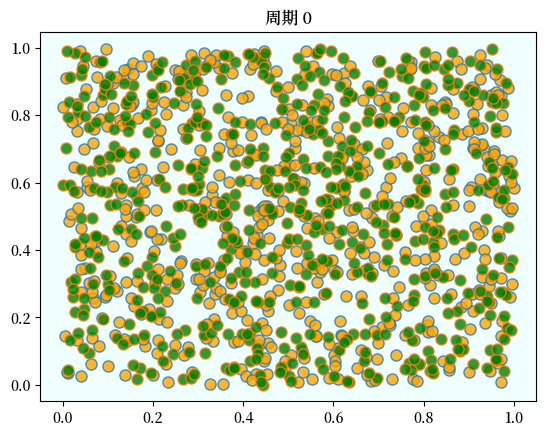

进入循环  1


进入循环  2


进入循环  3


进入循环  4


进入循环  5


进入循环  6


进入循环  7


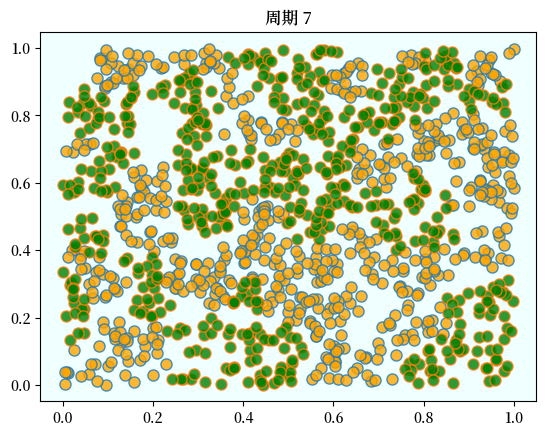

在 8 次迭代后收敛。


In [5]:
run_simulation()

如上所述，个体们最初是随机混合在一起的。

但经过几轮循环后，它们会被隔离到不同的区域。

在这个例子中，程序在一组个体中循环了几个周期后就终止了，这表明所有个体都达到了幸福的状态。

这些图片的惊人之处在于种族融合的瓦解速度是如此之快。

尽管实际上模型中的人并不介意和其他类型的人混居。

即使是有这些偏好，结果依旧是高度隔离。

## 练习

```{exercise-start}
:label: schelling_ex1
```

我们之前用到的面向对象式编程虽然整洁，但相比于过程式编程（即，围绕函数而非对象和方法的代码）更难优化。

尝试编写一个新版本的模型，它能够存储：

* 所有个体的位置，作为一个二维的NumPy浮点数数组。
* 所有个体的类型，作为一个平面的NumPy整数数组。

编写对这些数据进行操作的函数，并根据上述逻辑更新模型。

不过，要实现以下两个变化：

1. 个体们被随机提供移动机会（即，被随机选中并给予移动的机会）。
2. 个体们移动后，会有0.01的概率翻转其类型。

第二个变化为模型引入了额外的随机性。

（我们可以想象，每隔一段时间，就会有一个个体迁移到不同的城市，并以很小的概率被另一种类型的个体替换。）

```{exercise-end}
```
```{solution-start} schelling_ex1
:class: dropdown
```
解决方案如下

In [6]:
from numpy.random import uniform, randint

n = 1000                # 个体数量（个体编号从0到n-1）
k = 10                  # 视为邻居的个体数量
require_same_type = 5   # 希望 >= require_same_type 的邻居是相同类型

def initialize_state():
    locations = uniform(size=(n, 2))
    types = randint(0, high=2, size=n)   # 标签为零或一
    return locations, types


def compute_distances_from_loc(loc, locations):
    """ 计算位置 loc 到其他所有的点的距离。 """
    return np.linalg.norm(loc - locations, axis=1)

def get_neighbors(loc, locations):
    " 获取给定位置的所有邻居。 "
    all_distances = compute_distances_from_loc(loc, locations)
    indices = np.argsort(all_distances)   # 将个体按距离 loc 的远近排序
    neighbors = indices[:k]               # 保留最近的 k 个
    return neighbors

def is_happy(i, locations, types):
    happy = True
    agent_loc = locations[i, :]
    agent_type = types[i]
    neighbors = get_neighbors(agent_loc, locations)
    neighbor_types = types[neighbors]
    if sum(neighbor_types == agent_type) < require_same_type:
        happy = False
    return happy

def count_happy(locations, types):
    " 计算满意（快乐）的个体的数量。 "
    happy_sum = 0
    for i in range(n):
        happy_sum += is_happy(i, locations, types)
    return happy_sum

def update_agent(i, locations, types):
    " 如果个体不满意（不快乐），则移动个体。 "
    moved = False
    while not is_happy(i, locations, types):
        moved = True
        locations[i, :] = uniform(), uniform()
    return moved

def plot_distribution(locations, types, title, savepdf=False):
    " 绘制经过 cycle_num 轮循环后的个体分布情况。"
    fig, ax = plt.subplots()
    colors = 'orange', 'green'
    for agent_type, color in zip((0, 1), colors):
        idx = (types == agent_type)
        ax.plot(locations[idx, 0],
                locations[idx, 1],
                'o',
                markersize=8,
                markerfacecolor=color,
                alpha=0.8)
    ax.set_title(title)
    plt.show()

def sim_random_select(max_iter=100_000, flip_prob=0.01, test_freq=10_000):
    """
    每次更新时随机选择一个家庭进行模拟。

    以概率 `flip_prob` 翻转家庭的颜色。

    """

    locations, types = initialize_state()
    current_iter = 0

    while current_iter <= max_iter:

        # 随机选择一个个体并更新其状态
        i = randint(0, n)
        moved = update_agent(i, locations, types)

        if flip_prob > 0:
            # 以概率 epsilon 翻转个体 i 的类型
            U = uniform()
            if U < flip_prob:
                current_type = types[i]
                types[i] = 0 if current_type == 1 else 1

        # 每隔一定次数更新后，绘图并检查收敛情况
        if current_iter % test_freq == 0:
            cycle = current_iter / n
            plot_distribution(locations, types, f'迭代 {current_iter}')
            if count_happy(locations, types) == n:
                print(f"在迭代 {current_iter} 时收敛")
                break

        current_iter += 1

    if current_iter > max_iter:
        print(f"在迭代 {current_iter} 时终止")

```{solution-end}
```

当我们运行这个程序时，我们再次发现混合社区会瓦解，隔离现象会出现。

这里是一个运行的样例。

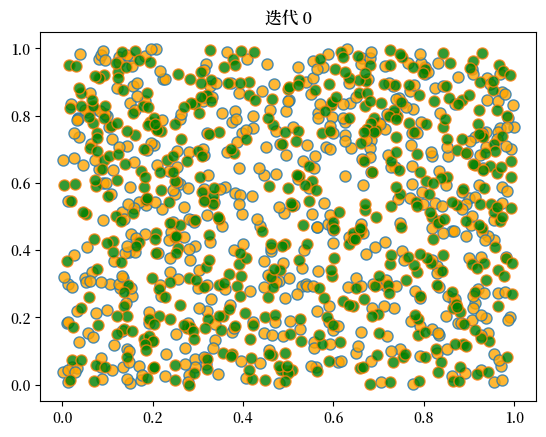

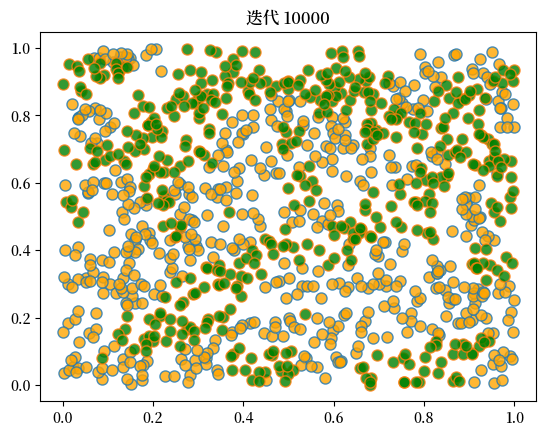

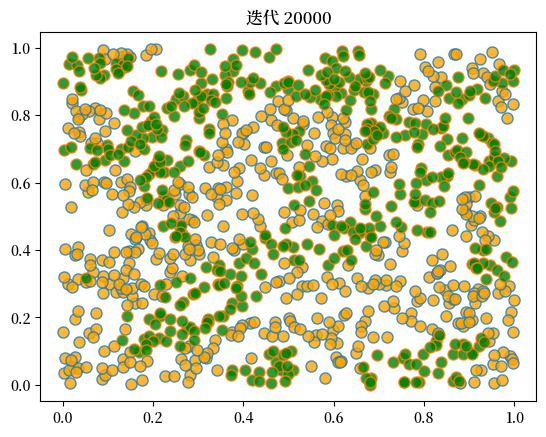

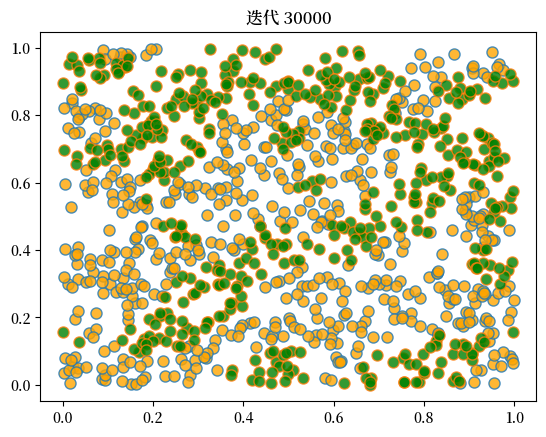

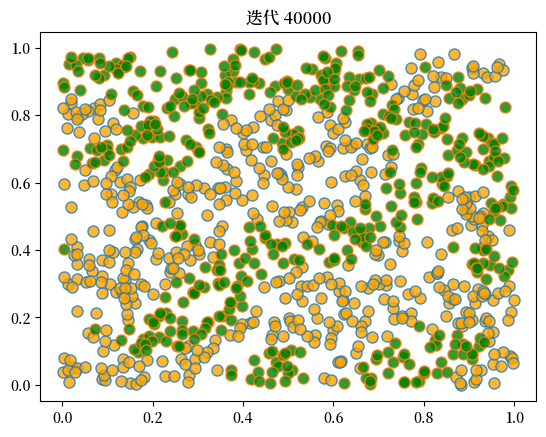

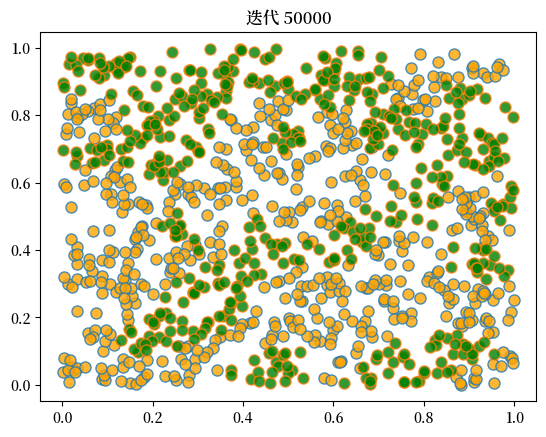

在迭代 50001 时终止


In [7]:
sim_random_select(max_iter=50_000, flip_prob=0.01, test_freq=10_000)